In [1]:
!pip install scikit-learn==1.1.3

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «....» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание проекта

Необходимо построить модель, предсказывающюю стоимость автомобиля по историческим данным.\
Имеется дата-сет со всеми основноми признаками для обучения модели: технические характеристики, комплектации и цены автомобилей.\
Будут учитываться все пар-ры модели, от качества до времени обучения и скорости работы.\
По заданию проекта, нужно использовать минимум 1 модель не бустинга, и сравнить ее с моделью бустинга и тут есть нюанс.\
Модели бустинга по-дефолту работают без предварительной кодировки признаков, а вот моделям без бустинга кодировка необходима.\
Примерный ход работы:
- Загрузим библиотеки
- Напишем пару пользовательских функций
- Загрузим данные
- Предобработка данных
- Кодирование категориальных данных
- Обучение моделей
- Общий вывод

# Импорты

In [2]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import catboost
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import randint as sp_randint

# Пользовательские функции

In [3]:
#  Функция для первичного анализа дата-сета
def analyze_df(df):
    # выводим размерность датафрейма
    display("Размерность датафрейма:")
    display(df.shape)

    
    # выводим информацию о датафрейме
    display("Информация о датафрейме:")
    display(df.info())

    
    # выводим статистическую информацию о датафрейме
    display("Статистическая информация о датафрейме:")
    display(df.describe())
    

    # выводим первые 10 строк датафрейма
    display("Первые 10 строк датафрейма:")
    display(df.head(10))
    

    # выодим кол-во пропусков
    display("Кол-во пропусков")
    display(df.isna().sum()[df.isna().sum() > 0])
    
    
    # выодим кол-во дубликатов
    display("Кол-во дубликатов")
    display(df.duplicated().sum()[df.duplicated().sum() > 0])
    
    # выводим типы данных в столбцах
    display("Типы данных в столбцах")
    display(df.dtypes)
    
    
    # выводим матрицу корреляции
    display(df.corr().style.background_gradient(cmap='coolwarm'))
    
    
    # выводим гистограммы
    display("Гистограммы данных")
    df.hist(figsize=(10, 13), bins = 30);
    plt.show()

In [4]:
#  Функция для вывода уникальных значений столбцов
def unique_values(dataframe):
    for column in dataframe.columns:
        unique_values = dataframe[column].unique()
        display(f"Уникальные значения в столбце '{column}':")
        display(unique_values)
        display()


# Загрузка файлов

In [5]:
#  Сохраним файлы в стандартную переменную, используя оба источника
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

# Подготовка данных

При подговке данных удалим дубликаты и выбросы во всех дата-сетах\

In [6]:
# Приводим значения столбцов к "хорошему тону"
data = data.rename(
columns={ 
    'DateCrawled' : 'date_crawled',
    'Price' : 'price',
    'VehicleType' : 'vehicle_type',
    'RegistrationYear': 'registration_year',
    'Gearbox' : 'gearbox',
    'Power' : 'power',
    'Model' : 'model',
    'Kilometer' : 'kilometer',
    'RegistrationMonth' : 'registration_month',
    'FuelType' : 'fuel_type',
    'Brand' : 'brand',
    'Repaired' : 'repaired',
    'DateCreated' : 'date_created',
    'NumberOfPictures' : 'number_of_pictures',
    'PostalCode' : 'postal_code',
    'LastSeen' : 'last_seen'
    
 } 
)

'Размерность датафрейма:'

(354369, 16)

'Информация о датафрейме:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

None

'Статистическая информация о датафрейме:'

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


'Первые 10 строк датафрейма:'

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


'Кол-во пропусков'

vehicle_type    37490
gearbox         19833
model           19705
fuel_type       32895
repaired        71154
dtype: int64

'Кол-во дубликатов'

array([4])

'Типы данных в столбцах'

date_crawled          object
price                  int64
vehicle_type          object
registration_year      int64
gearbox               object
power                  int64
model                 object
kilometer              int64
registration_month     int64
fuel_type             object
brand                 object
repaired              object
date_created          object
number_of_pictures     int64
postal_code            int64
last_seen             object
dtype: object

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
price,1.000000,0.026916,0.158872,-0.333199,0.110581,nan,0.076055
registration_year,0.026916,1.000000,-0.000828,-0.053447,-0.011619,nan,-0.003459
power,0.158872,-0.000828,1.000000,0.024002,0.043380,nan,0.021665
kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,nan,-0.007698
registration_month,0.110581,-0.011619,0.043380,0.009571,1.000000,nan,0.013995
number_of_pictures,nan,nan,nan,nan,nan,nan,nan
postal_code,0.076055,-0.003459,0.021665,-0.007698,0.013995,nan,1.000000


'Гистограммы данных'

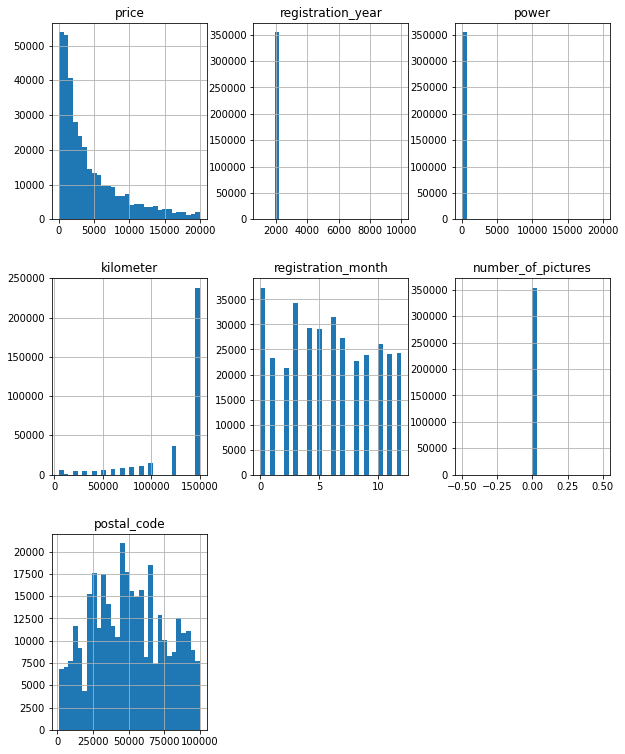

In [7]:
analyze_df(data)

In [8]:
unique_values(data)

"Уникальные значения в столбце 'date_crawled':"

array(['2016-03-24 11:52:17', '2016-03-24 10:58:45',
       '2016-03-14 12:52:21', ..., '2016-03-21 09:50:58',
       '2016-03-14 17:48:27', '2016-03-19 18:57:12'], dtype=object)

"Уникальные значения в столбце 'price':"

array([  480, 18300,  9800, ..., 12395, 18429, 10985])

"Уникальные значения в столбце 'vehicle_type':"

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

"Уникальные значения в столбце 'registration_year':"

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

"Уникальные значения в столбце 'gearbox':"

array(['manual', 'auto', nan], dtype=object)

"Уникальные значения в столбце 'power':"

array([    0,   190,   163,    75,    69,   102,   109,    50,   125,
         101,   105,   140,   115,   131,    60,   136,   160,   231,
          90,   118,   193,    99,   113,   218,   122,   129,    70,
         306,    95,    61,   177,    80,   170,    55,   143,    64,
         286,   232,   150,   156,    82,   155,    54,   185,    87,
         180,    86,    84,   224,   235,   200,   178,   265,    77,
         110,   144,   120,   116,   184,   126,   204,    88,   194,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    85,    73,   192,    68,    66,   299,
          74,    52,   147,    65,   310,    71,    97,   239,   203,
           5,   300,   103,   258,   320,    63,    81,   148,    44,
         145,   230,   280,   260,   104,   188,   333,   186,   117,
         141,    59,   132,   234,   158,    39,    92,    51,   135,
          53,   209,

"Уникальные значения в столбце 'model':"

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

"Уникальные значения в столбце 'kilometer':"

array([150000, 125000,  90000,  40000,  30000,  70000,   5000, 100000,
        60000,  20000,  80000,  50000,  10000])

"Уникальные значения в столбце 'registration_month':"

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

"Уникальные значения в столбце 'fuel_type':"

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

"Уникальные значения в столбце 'brand':"

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

"Уникальные значения в столбце 'repaired':"

array([nan, 'yes', 'no'], dtype=object)

"Уникальные значения в столбце 'date_created':"

array(['2016-03-24 00:00:00', '2016-03-14 00:00:00',
       '2016-03-17 00:00:00', '2016-03-31 00:00:00',
       '2016-04-04 00:00:00', '2016-04-01 00:00:00',
       '2016-03-21 00:00:00', '2016-03-26 00:00:00',
       '2016-04-07 00:00:00', '2016-03-15 00:00:00',
       '2016-03-11 00:00:00', '2016-03-20 00:00:00',
       '2016-03-23 00:00:00', '2016-03-27 00:00:00',
       '2016-03-12 00:00:00', '2016-03-13 00:00:00',
       '2016-03-18 00:00:00', '2016-03-10 00:00:00',
       '2016-03-07 00:00:00', '2016-03-09 00:00:00',
       '2016-03-08 00:00:00', '2016-04-03 00:00:00',
       '2016-03-29 00:00:00', '2016-03-25 00:00:00',
       '2016-03-28 00:00:00', '2016-03-30 00:00:00',
       '2016-03-22 00:00:00', '2016-02-09 00:00:00',
       '2016-03-05 00:00:00', '2016-04-02 00:00:00',
       '2016-03-16 00:00:00', '2016-03-19 00:00:00',
       '2016-04-05 00:00:00', '2016-03-06 00:00:00',
       '2016-02-12 00:00:00', '2016-03-03 00:00:00',
       '2016-03-01 00:00:00', '2016-03-04 00:0

"Уникальные значения в столбце 'number_of_pictures':"

array([0])

"Уникальные значения в столбце 'postal_code':"

array([70435, 66954, 90480, ..., 38528, 38325, 31096])

"Уникальные значения в столбце 'last_seen':"

array(['2016-04-07 03:16:57', '2016-04-07 01:46:50',
       '2016-04-05 12:47:46', ..., '2016-03-19 20:44:43',
       '2016-03-29 10:17:23', '2016-03-21 10:42:49'], dtype=object)

In [9]:
# Удалим выбросы

# Удаляем значения меньше 500 в столбце "price"
data = data[data['price'] >= 500]

# Удаляем значения меньше 1960 и больше 2016 в столбце "registration_year"
data = data[(data['registration_year'] >= 1960) & (data['registration_year'] <= 2016)]

# Удаляем значения меньше 50 и больше 500 в столбце "power"
data = data[(data['power'] >= 50) & (data['power'] <= 500)]

# Проверяем
display(data['price'].unique(), data['registration_year'].unique(), data['power'].unique())

array([18300,  9800,  1500, ..., 12395, 18429, 10985])

array([2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2007, 2009, 2002,
       1990, 1981, 2003, 2016, 1991, 1984, 2006, 1999, 2012, 2010, 2000,
       1992, 1997, 2013, 1994, 1996, 1989, 2015, 1985, 1983, 1969, 1993,
       1971, 1987, 1973, 1988, 1980, 1986, 1976, 1965, 1974, 1982, 1978,
       1979, 1972, 1977, 1961, 1970, 1968, 1963, 1966, 1975, 1960, 1967,
       1962, 1964])

array([190, 163,  75,  69, 102, 109, 125, 101, 105, 140, 115, 131, 136,
       160, 231, 118, 193,  99,  50,  60, 113, 218, 122, 129,  70, 306,
        95,  61, 177, 170,  55, 143, 232, 150, 156,  80,  82,  90, 185,
        87, 180,  86,  84, 224, 235, 200, 178, 265,  77, 110, 120,  54,
       286, 116, 184, 126, 204,  88, 194,  64, 305, 197, 179, 250, 313,
       165,  98, 130, 114, 211,  56, 201, 213, 107,  83, 174, 100, 220,
        73, 192,  68,  66, 299,  74,  58,  52, 147, 310,  71,  97,  65,
       239, 203, 144, 300, 103,  85, 258, 320,  63,  81, 148, 145, 280,
       260, 104, 188, 333, 186, 117, 141, 132, 155, 234, 158,  92,  51,
       135,  59, 230, 209, 146,  67, 106, 166, 276, 344,  72, 249, 237,
       245, 111, 326, 279, 138, 175,  96, 226, 301, 334, 128, 133, 124,
       219, 241, 167,  94, 182, 196, 238, 228, 112, 272, 139,  79, 256,
       360, 243, 252, 396, 340, 121, 345, 187, 289, 222, 198, 284, 450,
       233, 387, 347, 172,  57, 137, 212, 476, 314, 173, 290, 20

In [10]:
# Удаляем неинформативные столбцы
data = data.drop(['date_crawled', 'last_seen', 'registration_month', 'postal_code', 'date_created', 'number_of_pictures'],
                 axis=1)

In [11]:
data.head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes


In [12]:
# Удаляем дубликаты
data.drop_duplicates(inplace=True)
data = data.reset_index(drop=True)

# Проверяем
data.duplicated().sum()

0

In [13]:
data.isna().sum()

price                    0
vehicle_type          7933
registration_year        0
gearbox               4039
power                    0
model                 8909
kilometer                0
fuel_type            12022
brand                    0
repaired             33273
dtype: int64

In [14]:
# Используем заглушки для "второстепенных" признаков, чтобы не терять выборку
data.loc[data['vehicle_type'].isna(), 'vehicle_type'] = 'unknown'
data.loc[data['gearbox'].isna(), 'gearbox'] = 'unknown'
data.loc[data['fuel_type'].isna(), 'fuel_type'] = 'unknown'

In [15]:
# Удаляем остальные пропуски
data.dropna(inplace=True)
data = data.reset_index(drop=True)

# Проверяем
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

## Вывод о подготовке данных
Было найдено всего 4 дубликата - удалены.\
А вот с пропусками ситуация куда хуже. В данных имелось до 20% пропусков.\
Некоторые пропуски заполнены заглушками.

# Обучение моделей

## Применим технику Ordinal Encoding для кодировки категориальных признаков

Порядковое кодирование не увеличивает область признаков в отличие от OHE. Также оно подхидит для моделей использующих деревья в качестве базовых моделей.\
Но решающий фактор: в учебном окружении имееются только 2 вида кодирования (OHE & Ordinal) так что за не имением альтернатив...

In [16]:
data.dtypes

price                 int64
vehicle_type         object
registration_year     int64
gearbox              object
power                 int64
model                object
kilometer             int64
fuel_type            object
brand                object
repaired             object
dtype: object

In [17]:
# Объявим переменные для деления дата-сета
features = data.drop("price", axis=1)
target = data["price"]

# Разделяем датафрейм на тренировочную и тестовую выборки в пропорции 8:2
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                             target,
                                                                             test_size=0.2,
                                                                             random_state=12345)

In [18]:
# Отделим категориальные признаки для последующей кодировки
cat_features_train = features_train.select_dtypes(include=['object']).columns
num_features_train = features_train.drop(columns=cat_features_train)
cat_features_test = features_test.select_dtypes(include=['object']).columns
num_features_test = features_test.drop(columns=cat_features_test)

In [19]:
# Создаем OrdinalEncoder
encoder = OrdinalEncoder()

# Применяем метод fit_transform к категориальным столбцам на тренировочной выборке и сразу-же собираем датафрейм
encoded_train = encoder.fit_transform(features_train[cat_features_train])
encoded_train_df = pd.DataFrame(encoded_train, columns=cat_features_train, index=features_train.index)

# Применяем метод transform к тестовой выборке и сразу-же собираем датафрейм
encoded_test = encoder.transform(features_test[cat_features_test])
encoded_test_df = pd.DataFrame(encoded_test, columns=cat_features_test, index=features_test.index)

In [20]:
# Конкатенация категориальных и численных признаков для тренировочной выборки
features_train_tuned = pd.concat([num_features_train, encoded_train_df], axis=1)

# Конкатенация категориальных и численных признаков для тестовой выборки
features_test_tuned = pd.concat([num_features_test, encoded_test_df], axis=1)

features_train_tuned.shape, features_test_tuned.shape

((159177, 9), (39795, 9))

In [21]:
# Создание метрики качества RMSE с помощью Лямбда-функции
scoring = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False), greater_is_better=False)

## Random Forest

In [23]:
%%time

rf = RandomForestRegressor(n_jobs=-1)

# Поиск гиперпараметров
rf_param_dist = {
    'n_estimators': range (50, 500),
    'max_depth': range(3, 9)}

# RandomizedSearchCV для поиска гиперпараметров
random_search_rf = RandomizedSearchCV(rf,
                                   param_distributions=rf_param_dist,
                                   n_iter=10,
                                   cv=5,
                                   scoring=scoring,
                                   random_state=12345)

# Производим поиск оптимальных гиперпараметров
random_search_rf.fit(features_train_tuned, target_train)

# Выводим наилучшие гиперпараметры и значение метрики
print("Наилучшие гиперпараметры:", random_search_rf.best_params_)

# Используем модель с наилучшими гиперпараметрами
rf_model = RandomForestRegressor(**random_search_rf.best_params_)

rf_model.fit(features_train_tuned, target_train)
rf_predict = rf_model.predict(features_test_tuned)
rmse_rf = mean_squared_error(target_test, rf_predict, squared=False)
print('RMSE for Random Forest: ',rmse_rf)

Наилучшие гиперпараметры: {'n_estimators': 403, 'max_depth': 7}
RMSE for Random Forest:  2161.4092986025503
CPU times: user 17min 58s, sys: 1.16 s, total: 17min 59s
Wall time: 17min 59s


## CatBoost

In [24]:
%%time
# Создаем модель CatBoost Regressor
cat = CatBoostRegressor()

# Поиск параметров
cat_param_grid = {'max_depth': range(3, 9),
             'iterations': range(50,500)}

# Запуск RandomizedSearchCV для поиска оптималтных гиперпараметров
random_search = RandomizedSearchCV(cat, param_distributions=cat_param_grid, n_iter=10, cv=5, scoring=scoring)
random_search.fit(features_train_tuned, target_train)

# Лучшие найденные гиперпараметры
best_params_cat = random_search.best_params_
print("CatBoost best parameters:", best_params_cat)

# Создание и обучение модели с выбранными параметрами на тренировочной выборке
best_cat = CatBoostRegressor(**best_params_cat)
best_cat.fit(features_train_tuned, target_train, verbose=False)

# Прогнозирование на тестовых данных
y_test_pred_cat = best_cat.predict(features_test_tuned)

# Оценка качества модели на тестовых данных с использованием метрики RMSE
rmse_test_cat = mean_squared_error(target_test, y_test_pred_cat, squared=False)
print(f"CatBoost test RMSE: {rmse_test_cat}")


Learning rate set to 0.170078
0:	learn: 4281.7523222	total: 63.9ms	remaining: 28.4s
1:	learn: 3894.5557646	total: 76.1ms	remaining: 16.9s
2:	learn: 3595.8550239	total: 88.3ms	remaining: 13s
3:	learn: 3345.3392191	total: 101ms	remaining: 11.1s
4:	learn: 3155.3351904	total: 113ms	remaining: 9.97s
5:	learn: 2990.8807349	total: 126ms	remaining: 9.19s
6:	learn: 2860.6813626	total: 138ms	remaining: 8.62s
7:	learn: 2750.6666069	total: 151ms	remaining: 8.22s
8:	learn: 2665.4707945	total: 163ms	remaining: 7.89s
9:	learn: 2599.9197532	total: 175ms	remaining: 7.62s
10:	learn: 2535.4449482	total: 187ms	remaining: 7.37s
11:	learn: 2483.1237198	total: 199ms	remaining: 7.17s
12:	learn: 2431.7710565	total: 211ms	remaining: 7s
13:	learn: 2391.0678007	total: 223ms	remaining: 6.85s
14:	learn: 2355.2221961	total: 234ms	remaining: 6.72s
15:	learn: 2324.4292430	total: 246ms	remaining: 6.6s
16:	learn: 2295.2797425	total: 258ms	remaining: 6.5s
17:	learn: 2268.8526067	total: 270ms	remaining: 6.41s
18:	learn: 2

## XGBoost

In [25]:
%%time

# Создание модели XGBoost
model_xg = xgb.XGBRegressor(random_state=12345)

# Поиск гиперпараметров
param_grid_xg = {'max_depth': [3,9],
                'n_estimators': range(50, 500)}

# Создание RandomizedSearchCV
random_search_xg = RandomizedSearchCV(
    estimator=model_xg,
    param_distributions=param_grid_xg,
    scoring=scoring,
    n_iter=10,
    cv=5,
    verbose=1,
    random_state=12345
)

# Поиск наилучших гиперпараметров
random_search_xg.fit(features_train_tuned, target_train)

# Вывод наилучших параметров
xg_best_params = random_search_xg.best_params_
print("Наилучшие параметры:", xg_best_params)

# Обучение модели с наилучшими гиперпараметрами
best_xg = xgb.XGBRegressor(**xg_best_params)
best_xg.fit(features_train_tuned, target_train)

# Прогнозирование на тестовых данных
y_pred_xg = best_xg.predict(features_test_tuned)

# Вычисление RMSE на тестовых данных
rmse_xg = np.sqrt(mean_squared_error(target_test, y_pred_xg))
print("XGBoost test RMSE:", rmse_xg)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Наилучшие параметры: {'n_estimators': 108, 'max_depth': 9}
XGBoost test RMSE: 1583.3458665517169
CPU times: user 54min 55s, sys: 10.2 s, total: 55min 5s
Wall time: 55min 35s


## LightGBM

In [26]:
%%time

# Создание модели LightGBM
model_lgb = lgb.LGBMRegressor()

# Поиск гиперпараметров
param_grid_lgb = {'n_estimators': range(3, 9),
                 'max_depth': range(50, 500)}

# Создание RandomizedSearchCV
random_search_lgb = RandomizedSearchCV(model_lgb,
                                       param_distributions=param_grid_lgb,
                                       n_iter=10,
                                       scoring=scoring,
                                       cv=5,
                                       n_jobs=-1)

# Подгонка модели и подбор гиперпараметров
random_search_lgb.fit(features_train_tuned, target_train)

# Вывод наилучших гиперпараметров 
print("Best LightGBM parameters found: ", random_search_lgb.best_params_)

# Получение наилучшей модели
best_lgb = random_search_lgb.best_estimator_

# Оценка наилучшей модели на тестовых данных
y_pred_lgb = best_lgb.predict(features_test_tuned)
rmse_lgb = np.sqrt(mean_squared_error(target_test, y_pred_lgb))
print("LightGBM RMSE on test data: ", rmse_lgb)

Best LightGBM parameters found:  {'n_estimators': 8, 'max_depth': 370}
Best LightGBM RMSE:  -2930.186594005948
LightGBM RMSE on test data:  2910.18445147491
CPU times: user 25.6 s, sys: 96.9 ms, total: 25.7 s
Wall time: 26.2 s


# Анализ моделей

Проведем сравнение моделей учитывая значение метрики RMSE и времени обучения

In [27]:
# Создадим дата-сет для наглядности
idx = ['RandomForest','CatBoostRegressor', 'XGBoost', 'LGBMRegressor']

comparing_data = [
    {'time': 18, 'rmse': rmse_rf },
    {'time': 4, 'rmse': rmse_cat },
    {'time': 55, 'rmse': rmse_xg },
    {'time': 0.3, 'rmse': rmse_lgb },
]

comparing_table = pd.DataFrame(comparing_data, index=idx)
comparing_table

SyntaxError: invalid syntax (1833481564.py, line 8)

# Итоговый вывод

В заключении можем утверждать:
- LightGBM не прошла пороговое значение метрики RMSE в пределе 2500.
- Модели CatBoost и XGBoost справились почти с одинаковым успехом касаемо метрики. Разница составила около 20 пунков.
А вот касаемо времени CatBoost оказалась на порядки быстрее (4 мин против 55 мин у XGBoost).
- LightGBM просчитывается около 26 сек. Стоит отметить крайне малое время исполнения. В связи с этим можно было бы осуществить более подробную настройку гиперпараметрови добиться лучшего результата.
- Целью проекта было сравнение данных моделей, и для чистоты эксперемента была продемонстрирована их работа при одинаковом подборе гиперпараметров.
- Пальму первенства присуждаем регрессору CatBoost. Разница во времени с конкурентом (XGBoost) коллоссальна!

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей